In [1098]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix


#### Read Data

In [1099]:
df = pd.read_csv('../data/stocks_quarterly.csv')

df2 = pd.read_csv('../data/new_data_test.csv')

df = pd.concat([df,df2])

In [1100]:
df

,fiscalDateEnding,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,surprisePercentage,price,nasd_price,next_year_date,next_year_price,nasd_ny_price,symbol,Nasdaq_Performance,Stock_Performance,Label
0,2020-12-31,4.027000e+09,4.027000e+09,4.485000e+09,1.240000e+09,-2.515000e+09,186000000.0,NaN,1.127000e+09,5000000.0,...,6.3380,18.100000,13337.160156,2022-01-28,15.640000,13770.570313,AAL,3.249643,-13.591160,0
1,2020-09-30,-2.310000e+09,2.833000e+09,5.143000e+09,1.156000e+09,-2.871000e+09,70000000.0,NaN,1.941000e+09,5000000.0,...,3.7309,13.150000,11506.009766,2021-10-22,19.150000,15090.200195,AAL,31.150594,45.627378,1
2,2020-06-30,-2.601000e+09,1.368000e+09,3.969000e+09,8.660000e+08,-2.486000e+09,43000000.0,NaN,1.133000e+09,10000000.0,...,0.9575,11.770000,10461.419922,2021-07-23,21.200001,14836.990234,AAL,41.825778,80.118946,1
3,2020-03-31,1.241000e+09,8.258000e+09,7.017000e+09,2.197000e+09,-2.549000e+09,305000000.0,NaN,2.857000e+09,21000000.0,...,-12.5218,12.010000,8889.549805,2021-04-30,21.719999,13962.679688,AAL,57.068468,80.849283,1
4,2019-12-31,1.118900e+10,1.131300e+10,1.240000e+08,2.633000e+09,7.290000e+08,503000000.0,NaN,1.240000e+08,24000000.0,...,-0.5104,28.799999,9402.480469,2021-01-22,15.820000,13543.059570,AAL,44.037093,-45.069444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,2020-03-31,1.351000e+06,2.928000e+06,1.577000e+06,1.577000e+06,7.460000e+05,605000.0,NaN,6.050000e+05,NaN,...,NaN,2.220000,10058.769531,2021-06-30,3.960000,14503.950195,HIHO,44.192092,78.378378,1
936,2019-12-31,1.211000e+06,3.590000e+06,2.379000e+06,2.379000e+06,3.360000e+05,875000.0,NaN,8.750000e+05,NaN,...,NaN,2.030000,7700.100098,2021-03-31,3.730000,13246.870117,HIHO,72.035038,83.743846,1
937,2019-09-30,8.450000e+05,3.195000e+06,2.350000e+06,2.350000e+06,-1.690000e+05,1014000.0,NaN,1.014000e+06,NaN,...,NaN,1.620000,8972.599609,2020-12-30,4.000000,12870.000000,HIHO,43.436691,146.913580,1
938,2019-06-30,7.460000e+05,2.845000e+06,2.099000e+06,2.099000e+06,-1.660000e+05,912000.0,NaN,9.120000e+05,NaN,...,NaN,1.730000,7999.339844,2020-09-29,2.750000,11085.250000,HIHO,38.577060,58.959536,1


#### Drop columns with more tha 15% of nulls and not necesary

In [1101]:
cols_to_drop = df.isnull().mean().sort_values(ascending = False).head(45).index

cols_to_drop = list(cols_to_drop) + ['fiscalDateEnding','reportedDate','price','nasd_price',\
                                     'next_year_date','next_year_price','nasd_ny_price','symbol',\
                                     'Nasdaq_Performance', 'Stock_Performance']

df.drop(columns = cols_to_drop, inplace = True)

#### Drop duplicated rows

In [1102]:
df = df.drop_duplicates()

In [1103]:
df.shape

(10674, 47)

#### Split features and target

In [1071]:
X = df.drop(columns = 'Label')
y = df.Label

#### Split train and test

In [1027]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2)

#### Undersampling after spliting the data

In [1028]:
#undersample = RandomUnderSampler(sampling_strategy=0.75)
#X_train, y_train = undersample.fit_resample(X_train, y_train)

In [1029]:
y_train.value_counts()

0    5701
1    2838
Name: Label, dtype: int64

#### Impute Nulls

In [1030]:
pipline = make_pipeline(KNNImputer())

In [1072]:
#X = pipline.fit_transform(X)
X_train = pipline.fit_transform(X_train)
X_test = pipline.transform(X_test)

#### Random Forest Model

In [1032]:
from sklearn.ensemble import RandomForestClassifier
#max_depth=110 max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200

forest = RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

cv = cross_validate(forest,X_train,y_train,cv =5, scoring = ['accuracy','precision','recall'] )

#### Scores

In [1033]:
print(cv['test_accuracy'].mean())
print(cv['test_precision'].mean())
print(cv['test_recall'].mean())

0.6953966927748945
0.650623614034657
0.17969856174081525


#### Confusion Matrix Test Set

In [1034]:
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [1035]:
matrix = confusion_matrix(y_test,y_pred,labels = [1,0])

In [1036]:
matrix

array([[ 156,  567],
       [  65, 1347]])

#### Precision and Recall Test Set

In [1037]:
print(f'precision: {(matrix[0][0]/(matrix[0][0]+matrix[1][0])):.2f}')
print(f'recall: {(matrix[0][0]/(matrix[0][0]+matrix[0][1])):.2f}')                                 

precision: 0.71
recall: 0.22


## Test on New Data

#### Read Data

In [1038]:
df = pd.read_csv('../data/new_data_test.csv')

#### Drop columns with more tha 15% of nulls and not necesary

In [1039]:
df.drop(columns = cols_to_drop, inplace = True)

#### Drop duplicates 

In [945]:
df = df.drop_duplicates()

#### Split features and target

In [946]:
X_new = df.drop(columns = 'Label')
y_new = df.Label

In [947]:
X_new.shape

(940, 46)

#### Impute Nulls

In [948]:
X_new = pipline.transform(X_new)

#### Confusion Matrix Test Set

In [949]:
y_pred = forest.predict(X_new)
matrix = confusion_matrix(y_new,y_pred,labels = [1,0])
matrix

/Users/patriciogarbino/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[135, 191],
       [115, 499]])

#### Precision and Recall Test Set

In [950]:
print(f'precision: {(matrix[0][0]/(matrix[0][0]+matrix[1][0])):.2f}')
print(f'recall: {(matrix[0][0]/(matrix[0][0]+matrix[0][1])):.2f}')  

precision: 0.54
recall: 0.41


In [1040]:
xgb = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)

In [1041]:
cv = cross_validate(xgb,X_train,y_train,cv =5, scoring = ['accuracy','precision','recall'] )

In [1042]:
cv

{'fit_time': array([2.06419992, 1.98922992, 1.97083783, 1.97676802, 1.96889424]),
 'score_time': array([0.00822616, 0.00784087, 0.00777292, 0.00799394, 0.00800896]),
 'test_accuracy': array([0.68618267, 0.68618267, 0.69555035, 0.68852459, 0.67838313]),
 'test_precision': array([0.54341737, 0.54571429, 0.57317073, 0.54972376, 0.52486188]),
 'test_recall': array([0.34215168, 0.33626761, 0.33098592, 0.35035211, 0.335097  ])}

In [1043]:
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [1044]:
matrix = confusion_matrix(y_test,y_pred,labels = [1,0])

In [1045]:
print(f'precision: {(matrix[0][0]/(matrix[0][0]+matrix[1][0])):.2f}')
print(f'recall: {(matrix[0][0]/(matrix[0][0]+matrix[0][1])):.2f}')       

precision: 0.58
recall: 0.32


In [992]:
matrix

array([[363, 322],
       [255, 722]])

In [969]:
importance = forest.feature_importances_

In [300]:
forest_importances = pd.Series(importance, index=X.columns).sort_values(ascending = False)

In [301]:
forest_importances.to_csv('forest_importances.csv')

In [310]:
columns = forest_importances.head(34).index

In [311]:
columns

Index(['othe_esti', 'depr_surp', 'otherNonCurrrentAssets', 'comm_othe',
       'gros_prop', 'cost_esti', 'ebit_reta', 'surprisePercentage',
       'repo_esti', 'surprise', 'surp_esti', 'oper_esti', 'cost_tota',
       'tota_surp', 'othe_inte', 'otherCurrentAssets', 'gros_sell',
       'reta_repo', 'comm_surp', 'depr_esti', 'comm_esti', 'reta_othe',
       'gros_repo', 'gros_shor', 'othe_repo', 'inco_esti', 'cost_inte',
       'comm_tota', 'othe_oper', 'reta_oper', 'gros_esti', 'repo_surp',
       'cost_othe', 'othe_othe'],
      dtype='object')

In [322]:
df.shape

(9929, 485)

In [351]:
df = df[['othe_esti', 'depr_surp', 'otherNonCurrrentAssets', 'comm_othe',
       'gros_prop', 'cost_esti', 'ebit_reta', 'surprisePercentage',
       'repo_esti', 'surprise', 'surp_esti', 'oper_esti', 'cost_tota',
       'tota_surp', 'othe_inte', 'otherCurrentAssets', 'gros_sell',
       'reta_repo', 'comm_surp', 'depr_esti', 'comm_esti', 'reta_othe',
       'gros_repo', 'gros_shor', 'othe_repo', 'inco_esti', 'cost_inte',
       'comm_tota', 'othe_oper', 'reta_oper', 'gros_esti', 'repo_surp',
       'cost_othe', 'othe_othe','Label']]

In [290]:
importance_xgb = xgb.feature_importances_

In [294]:
xgb_importances = pd.Series(importance, index=df.columns[:-1]).sort_values(ascending = False)

In [295]:
xgb_importances.to_csv('xgb_importances.csv')

In [296]:
df.columns[:-1]

Index(['grossProfit', 'totalRevenue', 'costOfRevenue',
       'costofGoodsAndServicesSold', 'operatingIncome',
       'sellingGeneralAndAdministrative', 'operatingExpenses',
       'interestExpense', 'depreciationAndAmortization', 'incomeBeforeTax',
       ...
       'canarito_89', 'canarito_90', 'canarito_91', 'canarito_92',
       'canarito_93', 'canarito_94', 'canarito_95', 'canarito_96',
       'canarito_97', 'canarito_98'],
      dtype='object', length=484)

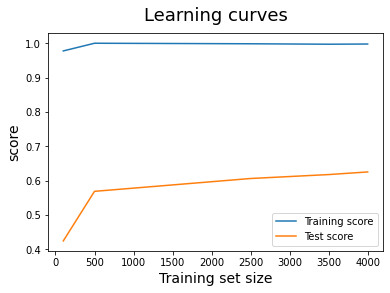

In [659]:
from sklearn.model_selection import learning_curve

train_sizes = [100,500,2500,3500,4000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=forest, X=X_train, y=y_train, train_sizes=train_sizes, cv=5, scoring = 'precision')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

In [1046]:
df.surprisePercentage

,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,operatingExpenses,interestExpense,depreciationAndAmortization,incomeBeforeTax,...,cashflowFromInvestment,cashflowFromFinancing,proceedsFromRepurchaseOfEquity,changeInCashAndCashEquivalents,netIncome_y,reportedEPS,estimatedEPS,surprise,surprisePercentage,Label
0,-8.700000e+07,3.563000e+09,3.650000e+09,2.794000e+09,-1.303000e+09,605000000.0,1.216000e+09,78000000.0,194000000.0,123000000,...,-152000000.0,-7.520000e+08,0.0,4.500000e+08,63000000,0.4400,0.1601,0.2799,174.8282,1
1,-3.680000e+08,2.970000e+09,3.338000e+09,2.552000e+09,-1.139000e+09,581000000.0,7.710000e+08,73000000.0,196000000.0,-370000000,...,-257000000.0,9.390000e+08,0.0,1.210000e+08,-619000000,-0.6000,-0.2730,-0.3270,-119.7802,1
2,4.200000e+07,3.645000e+09,3.603000e+09,2.903000e+09,-1.066000e+09,618000000.0,1.108000e+09,79000000.0,5000000.0,19000000,...,-216000000.0,-1.096000e+09,0.0,2.100000e+09,-392000000,0.1900,0.5319,-0.3419,-64.2790,0
3,3.987000e+09,7.591000e+09,3.604000e+09,2.976000e+09,3.357000e+09,591000000.0,6.300000e+08,76000000.0,199000000.0,108000000,...,-248000000.0,3.990000e+08,-24000000.0,-2.380000e+08,75000000,0.5000,0.4574,0.0426,9.3135,0
4,2.880000e+08,3.999000e+09,3.711000e+09,3.081000e+09,-7.360000e+08,579000000.0,1.024000e+09,75000000.0,195000000.0,281000000,...,-204000000.0,-8.720000e+08,-193000000.0,2.360000e+08,-96000000,0.9900,0.7833,0.2067,26.3884,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,1.351000e+06,2.928000e+06,1.577000e+06,1.577000e+06,7.460000e+05,605000.0,6.050000e+05,NaN,NaN,723000,...,NaN,NaN,NaN,NaN,563000,-0.0600,0.0000,-0.0600,NaN,1
936,1.211000e+06,3.590000e+06,2.379000e+06,2.379000e+06,3.360000e+05,875000.0,8.750000e+05,73000.0,NaN,379000,...,NaN,NaN,NaN,NaN,318000,0.1424,NaN,NaN,NaN,1
937,8.450000e+05,3.195000e+06,2.350000e+06,2.350000e+06,-1.690000e+05,1014000.0,1.014000e+06,73000.0,NaN,-94000,...,NaN,NaN,NaN,NaN,-94000,0.0800,NaN,NaN,NaN,1
938,7.460000e+05,2.845000e+06,2.099000e+06,2.099000e+06,-1.660000e+05,912000.0,9.120000e+05,51000.0,NaN,-113000,...,NaN,NaN,NaN,NaN,-102000,-0.0241,NaN,NaN,NaN,1


In [1073]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
data_projected = pca.fit_transform(X)

In [1084]:
data = pd.concat([pd.DataFrame(data_projected),y],axis =1)

In [1082]:
y = y.reset_index()['Label']